# **FloodNet: Segmentation of images during a flooding event**


**Authors**

*Group 3*
*  Chang Chun 
*  Maria Eremina
*  Tian Tian  

# 1. Setup

## 1.1 Check if GPU available


In [ ]:
import torch

print(torch.cuda.is_available())

True


## 1.2 Import packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
import torchvision.transforms.functional as TF
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
import os
import numpy as np
import pandas as pd
import random
import time
import copy
from tqdm.notebook import trange    
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.pyplot import MultipleLocator

## 1.3 Random seed

In [ ]:
seed = 3234           # the seed value used to initialise the random number generator of PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 2. Load Data

## 2.1 Data path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/IPEO_project_data")

os.getcwd() # check dir

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1fpRKcNX6eb_44mIhZbNuihE-JecpOzPV/IPEO_project_data'

In [ ]:
# paths for data upload
FILE_PATH = "/content/drive/MyDrive/IPEO_project_data" 
TRAIN_FEATURES_PATH = FILE_PATH + '/train/image'
TRAIN_LABELS_PATH = FILE_PATH + '/train/mask'
TEST_FEATURES_PATH = FILE_PATH + '/test/image'
TEST_LABELS_PATH = FILE_PATH + '/test/mask'
VAL_FEATURES_PATH = FILE_PATH + '/valid/image'
VAL_LABELS_PATH = FILE_PATH + '/valid/mask'

##  2.2 Write a PyTorch Dataset class

### Train & val data - with augmentation

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, label_dir, img_dir, transform=None):
        self.img_labels = label_dir
        self.img_dir = img_dir
        self.transform = transform
        self.len = len(os.listdir(self.img_labels))
        self.img_sort = sorted(os.listdir(self.img_dir))
        self.label_sort = sorted(os.listdir(self.img_labels))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_sort[idx])
        image = read_image(img_path).float()
        label_path = os.path.join(self.img_labels, self.label_sort[idx])
        label = read_image(label_path).float()
        image, label = self.augmentation(image, label)
        if self.transform:
            image = self.transform(image)
        return image, label
        
    def augmentation(self, image, label):
        # Resize
        resize = transforms.Resize((256, 256))
        image = resize(image)
        label = resize(label)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            label = TF.hflip(label)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            label = TF.vflip(label)

        # Rotation 45*
        degree = transforms.RandomRotation.get_params((0,90))
        image = TF.rotate(image, degree)
        label = TF.rotate(label, degree)
        return image, label

### Test data - without augmentation

In [ ]:
class CustomImageDatasetTEST(Dataset):
    def __init__(self, label_dir, img_dir,transform):
        self.img_labels = label_dir
        self.img_dir = img_dir
        self.transform = transform
        self.len = len(os.listdir(self.img_labels))
        self.img_sort = sorted(os.listdir(self.img_dir))
        self.label_sort = sorted(os.listdir(self.img_labels))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_sort[idx])
        image = read_image(img_path).float()
        label_path = os.path.join(self.img_labels, self.label_sort[idx])
        label = read_image(label_path).float()
        image, label = self.augmentation(image, label)
        if self.transform:
            image = self.transform(image)
        return image, label

    def augmentation(self, image, label):
        # Resize
        resize = transforms.Resize((256, 256))
        image = resize(image)
        label = resize(label)
        return image, label

## 2.3 Define transforms

In [ ]:
# Gaussian , Normalize

mean = torch.tensor([106.4888, 116.0904,  87.6063])
std = torch.tensor([39.8035, 36.5686, 41.5882])

transforms_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=5,sigma=0.5),
    transforms.Normalize(mean, std)
    ])

transforms_val = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

## 2.4 Dataloader - train, val, test

### with augmentation

In [ ]:
# transformed train dataset
train_set = CustomImageDataset(TRAIN_LABELS_PATH, TRAIN_FEATURES_PATH, transforms_train)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [ ]:
# transformed validation dataset
val_set = CustomImageDataset(VAL_LABELS_PATH, VAL_FEATURES_PATH, transforms_val)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

### without augmentation

In [ ]:
# transformed train dataset
# train_set = CustomImageDatasetTEST(TRAIN_LABELS_PATH, TRAIN_FEATURES_PATH, transforms_train)
# train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [ ]:
# transformed validation dataset
# val_set = CustomImageDatasetTEST(VAL_LABELS_PATH, VAL_FEATURES_PATH, transforms_val)
# val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

### test set

In [ ]:
test_set = CustomImageDatasetTEST(TEST_LABELS_PATH, TEST_FEATURES_PATH, transforms_val)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    

# 3. Build Model

## 3.1 U-Net

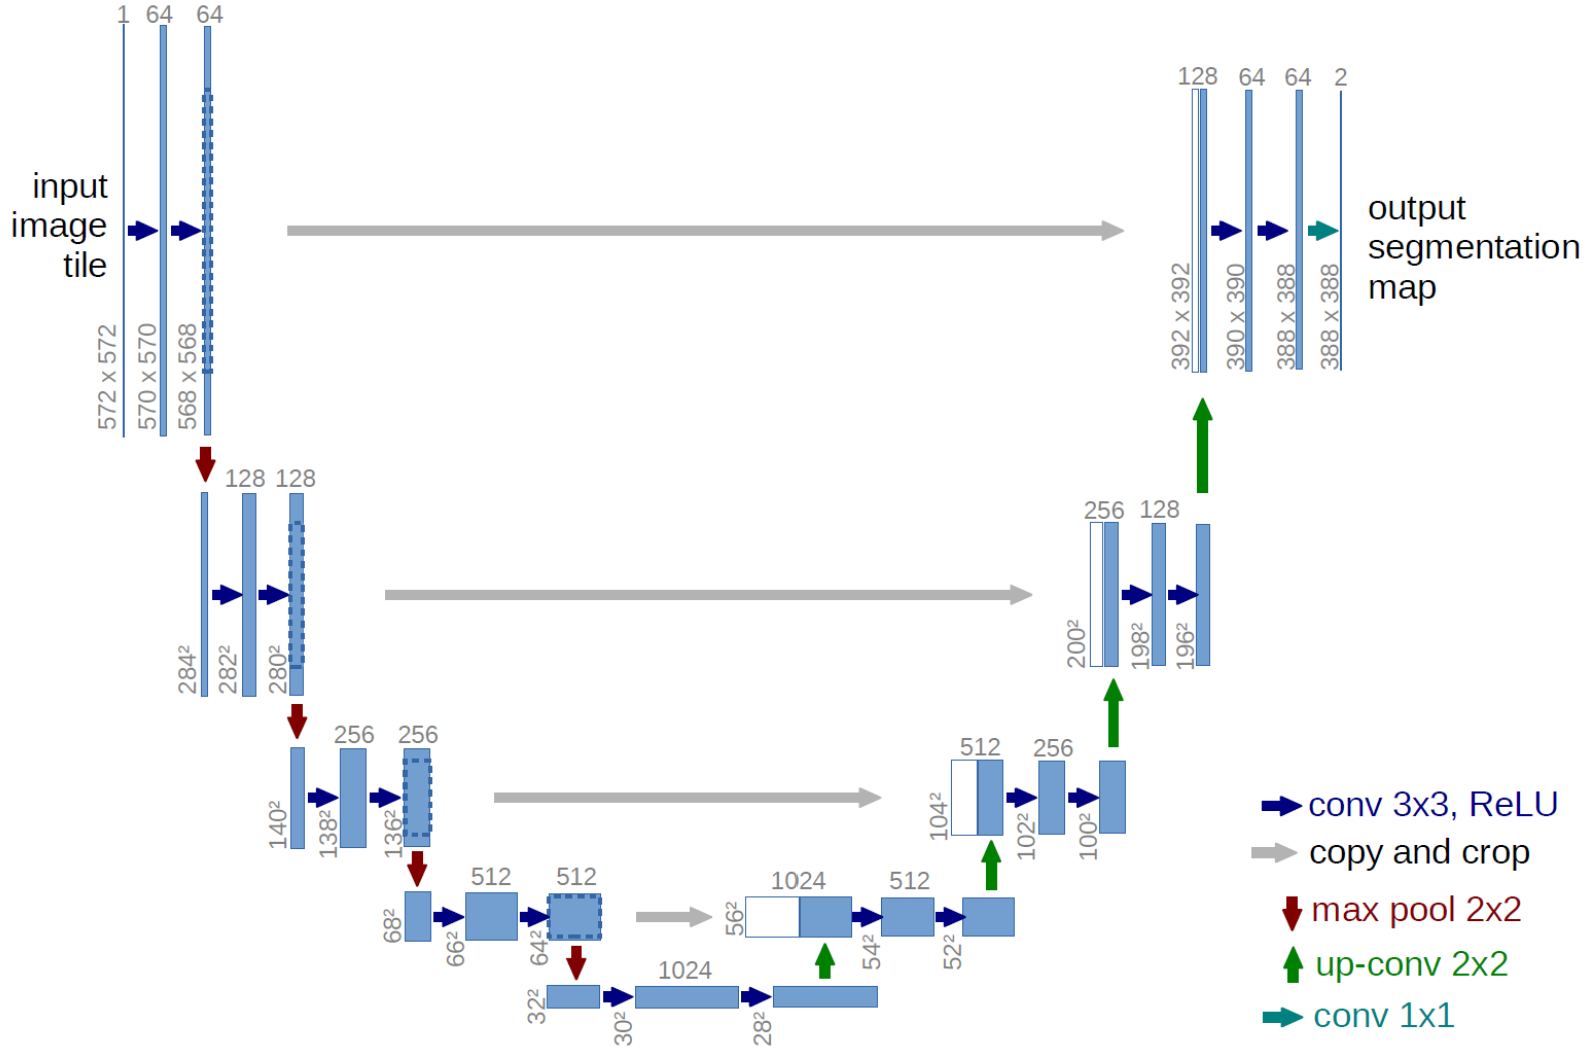

In [ ]:
class DummyConv(nn.Module):
    """(convolution => sigmoid)"""

    def __init__(self, in_channels, out_channels):            
        super().__init__()
            
        self.single_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid(inplace=True)
        )

    def forward(self, x):
        return self.single_conv(x)

    

class DummyNetwork(nn.Module):

    def __init__(self, n_channels):
        super(DummyNetwork, self).__init__()
        self.initial_layer = DummyConv(n_channels, 64)
        self.second_layer = DummyConv(64, 128)
        self.third_layer = DummyConv(128, 256)

    def forward(self, x):
        x1 = self.initial_layer(x)
        x2 = self.second_layer(x1)
        x3 = self.third_layer(x2)
        return x3

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => batch normalization => ReLU => convolution => batch normalization => ReLU)
    Batch normalization is a technique for normalization over mini-batches. 
    """
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), #torch.nn.BatchNorm2d(num_features=C if input : N,C,H,W)
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.dc1 = DoubleConv(n_channels, 64)
        self.mp1 = nn.MaxPool2d(2)
        self.dc2 = DoubleConv(64, 128)
        self.mp2 = nn.MaxPool2d(2)
        self.dc3 = DoubleConv(128, 256)
        self.mp3 = nn.MaxPool2d(2)
        self.dc4 = DoubleConv(256, 512)
        self.mp4 = nn.MaxPool2d(2)
        self.dc5 = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) #up conv
        self.dc6 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) #up conv
        self.dc7 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) #up conv
        self.dc8 = DoubleConv(256, 128)        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) #up conv
        self.dc9 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)


    def forward(self, x):
        
        x1 = self.dc1(x)
        x2 = self.mp1(x1)
        x2 = self.dc2(x2)       
        x3 = self.mp2(x2)
        x3 = self.dc3(x3)
        x4 = self.mp3(x3)
        x4 = self.dc4(x4)
        x5 = self.mp4(x4)
        x5 = self.dc5(x5)        

        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.dc6(x)
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.dc7(x)
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.dc8(x)
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.dc9(x)
        logits = self.outc(x)
        return logits

## 3.2 Create model

In [ ]:
# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=10)
model = model.to(device)

In [ ]:
# model details
from torchsummary import summary
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

# 4. Model training

## 4.1 Define Loss Function

In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    
    #one hot encoding for prediction
    #target = F.one_hot(target.astype('int'),10).transpose(-1,1)[..., 0]
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target):
    target = F.one_hot(target.long(),10).transpose(-1,1)[..., 0]
    bce_weight = 0.5
    bce = F.cross_entropy(pred.squeeze(dim=1), target.to(torch.float32))
    pred = F.softmax(pred,dim=1)
    dice = dice_loss(pred, target)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    return loss


## 4.2 Training model

### train epoch

In [ ]:
from tqdm.notebook import trange    

def train_epoch(data_loader, model, optimizer, scheduler):

    # set model to training mode
    model.train()
    model.to(device)

    # stats
    loss_total = 0
    oa_total = 0
    f1_total = 0
    confusion_total = 0
    class_names = [0,1,2,3,4,5,6,7,8,9]

    # iterate over dataset
    pBar = trange(len(data_loader))

    # load the images and masks
    for bi, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()

        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = calc_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            pred = torch.argmax(outputs,dim=1)
            loss_total += loss.item()
            oa_total += torch.mean((pred == labels).float()).item()
            f1_total += f1_score(labels.cpu().numpy().flatten().astype(int), pred.cpu().numpy().flatten().astype(int), average='weighted').item()
            confusion_total += confusion_matrix(labels.cpu().numpy().flatten().astype(int), pred.cpu().numpy().flatten().astype(int),labels=class_names) 

        # format progress bar
        pBar.set_description('Loss: {:.2f}, OA: {:.2f}, F1: {:.2f}'.format(
          loss_total/(bi+1),
          100 * oa_total/(bi+1),
          100 * f1_total/(bi+1)
        ))
        pBar.update(1)
    pBar.close()

    # normalise stats
    loss_total /= len(data_loader)
    oa_total /= len(data_loader)
    f1_total /= len(data_loader)

    scheduler.step()

    return model, loss_total, oa_total, f1_total, confusion_total

### valid epoch

In [ ]:
from tqdm.notebook import trange    

def valid_epoch(data_loader, model):

    # set model to training mode.
    model.eval()
    model.to(device)

    # stats
    loss_total = 0
    oa_total = 0
    f1_total = 0
    confusion_total = 0
    class_names = [0,1,2,3,4,5,6,7,8,9]

    # iterate over dataset
    pBar = trange(len(data_loader))

    # load the images and masks
    for bi, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = calc_loss(outputs, labels)

            pred = torch.argmax(outputs,dim=1)
            loss_total += loss.item()
            oa_total += torch.mean((pred == labels).float()).item()
            f1_total += f1_score(labels.cpu().numpy().flatten().astype(int), pred.cpu().numpy().flatten().astype(int), average='weighted').item()
            confusion_total += confusion_matrix(labels.cpu().numpy().flatten().astype(int), pred.cpu().numpy().flatten().astype(int),labels=class_names) 


        # format progress bar
        pBar.set_description('Loss: {:.2f}, OA: {:.2f}, F1: {:.2f}'.format(
          loss_total/(bi+1),
          100 * oa_total/(bi+1),
          100 * f1_total/(bi+1)
        ))
        pBar.update(1)
    pBar.close()

    # normalise stats
    loss_total /= len(data_loader)
    oa_total /= len(data_loader)
    f1_total /= len(data_loader)

    return loss_total, oa_total, f1_total, confusion_total

## 4.3 Training

In [ ]:
from torch.utils.data import Dataset
import os
import torchvision
import torch
from torchvision import models
import torch.nn as nn

num_epochs = 100
start_epoch = 0

# keep results
oas_train=[]
losses_train=[]
f1s_train=[]
oas_val=[]
losses_val=[]
f1s_val=[]
train_time = []
val_time=[]



### ------ Case_1: lr = 0.01 ----------------------------------------------
# optimizer = optim.AdamW(model.parameters(), lr=0.01)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)

### ------ Case_2: lr = 0.001 ---------------------------------------------
# optimizer = optim.AdamW(model.parameters(), lr=0.001)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)

### ------ Case_3: lr = 0.0001 --------------------------------------------
# optimizer = optim.AdamW(model.parameters(), lr=0.0001)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)

### ------ Case_4: lr = 0.0001, with scheduler -----------------------------
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)




# RESUME = False     # no saved checkpoint
RESUME = True     # have saved checkpoint

if RESUME:
    path_checkpoint = "/content/drive/MyDrive/IPEO_project_data/checkpoint/ckpt_case4_100.pth"  
    checkpoint = torch.load(path_checkpoint) 
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  
    start_epoch = checkpoint['epoch']  
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    losses_train = checkpoint['losses_train']
    losses_val = checkpoint['losses_val']
    oas_train = checkpoint['oas_train']
    oas_val = checkpoint['oas_val']
    f1s_train = checkpoint['f1s_train']
    f1s_val = checkpoint['f1s_val']
    train_time = checkpoint['train_time']
    val_time = checkpoint['val_time']

    


# do epochs
import time
for epoch in range(start_epoch, num_epochs):
    print('-' * 20)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    for param_group in optimizer.param_groups:
        print("LR", param_group['lr'])

    # training
    tic = time.time()
    model, loss_train, oa_train, f1_train, confusion_train = train_epoch(train_loader, model, optimizer, scheduler,) 
    toc_train = (time.time() - tic)

    # validation
    tic = time.time()
    loss_val, oa_val, f1_val, confusion_val = valid_epoch(val_loader, model)                 
    toc_val = (time.time() - tic)

  
    # save the loss,oa,f1,time for each epoch
    oas_train.append(oa_train)
    losses_train.append(loss_train)
    f1s_train.append(f1_train)

    oas_val.append(oa_val)
    losses_val.append(loss_val)
    f1s_val.append(f1_val)

    train_time.append(toc_train)
    val_time.append(toc_val)
  
  # print stats
    print('[Ep. {}/{}] Loss train: {:.2f}, val: {:.2f}; OA train: {:.2f}, val: {:.2f}; F1 train: {:.2f}, val: {:.2f}; time train: {:.2f}s, val: {:.2f}s'.format(
        epoch+1, num_epochs,
        loss_train, loss_val,
        100*oa_train, 100*oa_val,
        100*f1_train, 100*f1_val,
        toc_train, toc_val
    ))

    epoch += 1


    # save model
    if epoch == num_epochs:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'losses_train': losses_train,
            'losses_val': losses_val,
            'oas_train': oas_train,
            'oas_val': oas_val,
            'f1s_train': f1s_train,
            'f1s_val': f1s_val,
            'train_time': train_time,
            'val_time': val_time,
            'confusion_train': confusion_train,
            'confusion_val': confusion_val
        }
        if not os.path.isdir("/content/drive/MyDrive/IPEO_project_data/checkpoint"):
            os.mkdir("/content/drive/MyDrive/IPEO_project_data/checkpoint")
        torch.save(checkpoint, '/content/drive/MyDrive/IPEO_project_data/checkpoint/ckpt_case4_%s.pth' %(str(epoch)))


loss_train = losses_train[num_epochs-1]
oa_train = oas_train[num_epochs-1]
f1_train = f1s_train[num_epochs-1]
loss_val = losses_train[num_epochs-1]
oa_val = oas_val[num_epochs-1]
f1_val = f1s_val[num_epochs-1]


# perform final run on test set
loss_test, oa_test, f1_test, confusion_test = valid_epoch(test_loader, model)     

# print results
print('Split\tLoss\tOA\tF1\n-----------------------')
print('train\t{:.2f}\t{:.2f}\t{:.2f}'.format(loss_train, oa_train, f1_train))
print('val\t{:.2f}\t{:.2f}\t{:.2f}'.format(loss_val, oa_val, f1_val))
print('test\t{:.2f}\t{:.2f}\t{:.2f}'.format(loss_test, oa_test, f1_test))

  0%|          | 0/60 [00:00<?, ?it/s]

Split	Loss	OA	F1
-----------------------
train	0.63	0.52	0.80
val	0.63	0.49	0.78
test	0.73	0.76	0.75


# 5. Evaluation

In [ ]:
# if have saved checkpoint, run this cell

path_checkpoint = "/content/drive/MyDrive/IPEO_project_data/checkpoint/ckpt_case4_100.pth"  
checkpoint = torch.load(path_checkpoint) 
confusion_train = checkpoint['confusion_train']
confusion_val = checkpoint['confusion_val']
losses_train = checkpoint['losses_train']
losses_val = checkpoint['losses_val']
oas_train = checkpoint['oas_train']
oas_val = checkpoint['oas_val']
f1s_train = checkpoint['f1s_train']
f1s_val = checkpoint['f1s_val']
train_time = checkpoint['train_time']
val_time = checkpoint['val_time']

## 5.1 Losses, OA, F1 per epoch

In [ ]:
# creat path for saving results
if not os.path.isdir("/content/drive/MyDrive/IPEO_project_data/results"):
    os.mkdir("/content/drive/MyDrive/IPEO_project_data/results")

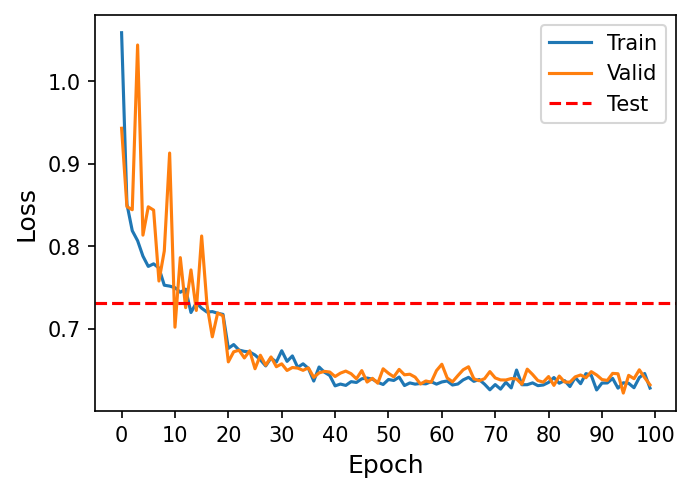

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# loss
plt.figure(dpi=150,figsize=(5,3.5))
plt.plot(losses_train)
plt.plot(losses_val)
plt.axhline(y=loss_test, ls='--', c='red')

x = MultipleLocator(10)    
ax = plt.gca()
ax.xaxis.set_major_locator(x)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(['Train','Valid','Test'],loc=1)
# plt.savefig('/content/drive/MyDrive/IPEO_project_data/results/loss_4.png')
plt.show()

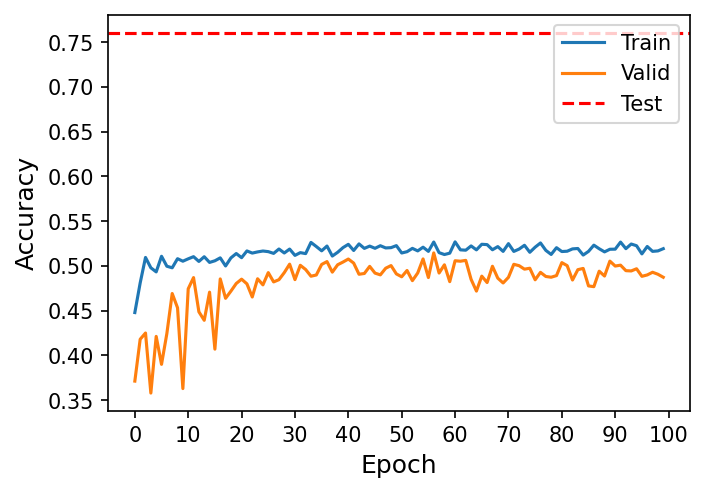

In [ ]:
# OA
plt.figure(dpi=150,figsize=(5,3.5))
plt.plot(oas_train)
plt.plot(oas_val)
plt.axhline(y=oa_test, ls='--', c='red')

x = MultipleLocator(10)    
ax = plt.gca()
ax.xaxis.set_major_locator(x)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(['Train','Valid','Test'],loc=1)
# plt.savefig('/content/drive/MyDrive/IPEO_project_data/results/oa_4.png')
plt.show()

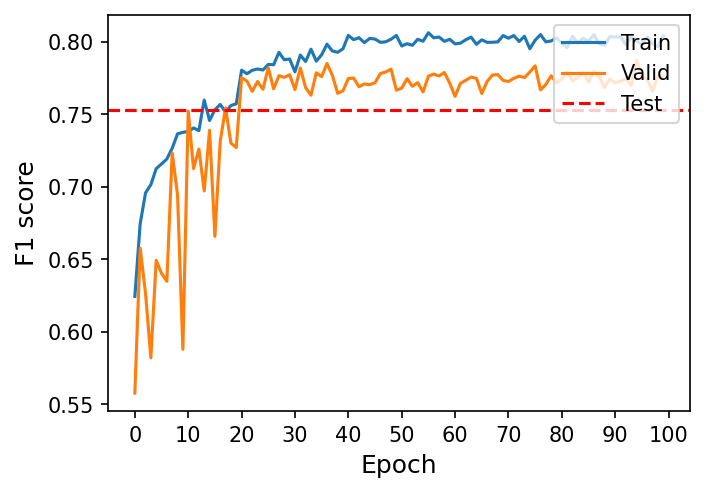

In [ ]:
# F1
plt.figure(dpi=150,figsize=(5,3.5))
plt.plot(f1s_train)
plt.plot(f1s_val)
plt.axhline(y=f1_test, ls='--', c='red')

x = MultipleLocator(10)    
ax = plt.gca()
ax.xaxis.set_major_locator(x)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('F1 score', fontsize=12)
plt.legend(['Train','Valid','Test'],loc=1)
# plt.savefig('/content/drive/MyDrive/IPEO_project_data/results/f1_4.png')
plt.show()

## 5.2 Train vs Valid Running time

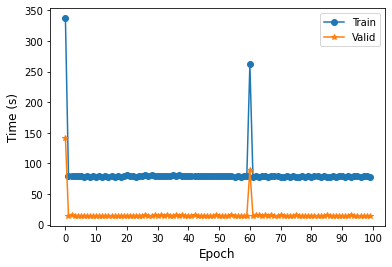

In [ ]:
# running time
plt.plot(train_time,'-o')
plt.plot(val_time,'-*')
x = MultipleLocator(10)    
ax = plt.gca()
ax.xaxis.set_major_locator(x)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.legend(['Train','Valid'],loc=1)
# plt.title('Train vs Valid Running time')
plt.show()

In [ ]:
train_time_epoch = sum(train_time)/num_epochs
val_time_epoch = sum(val_time)/num_epochs
print('average running time per epoch - train (s): ', train_time_epoch)
print('average running time per epoch - valid (s): ', val_time_epoch)

average running time per epoch - train (s):  83.44689055681229
average running time per epoch - valid (s):  16.755151050090788


## 5.3 Confusion matrix

### test

([<matplotlib.axis.YTick at 0x7fa7c8518070>,
 [Text(0, 0.5, 'Background'),
  Text(0, 1.5, 'Building-flooded'),
  Text(0, 2.5, 'Building-non-flooded'),
  Text(0, 3.5, 'Road-flooded'),
  Text(0, 4.5, 'Road-non-flooded'),
  Text(0, 5.5, 'Water'),
  Text(0, 6.5, 'Tree'),
  Text(0, 7.5, 'Vehicle'),
  Text(0, 8.5, 'Pool'),
  Text(0, 9.5, 'Grass')])

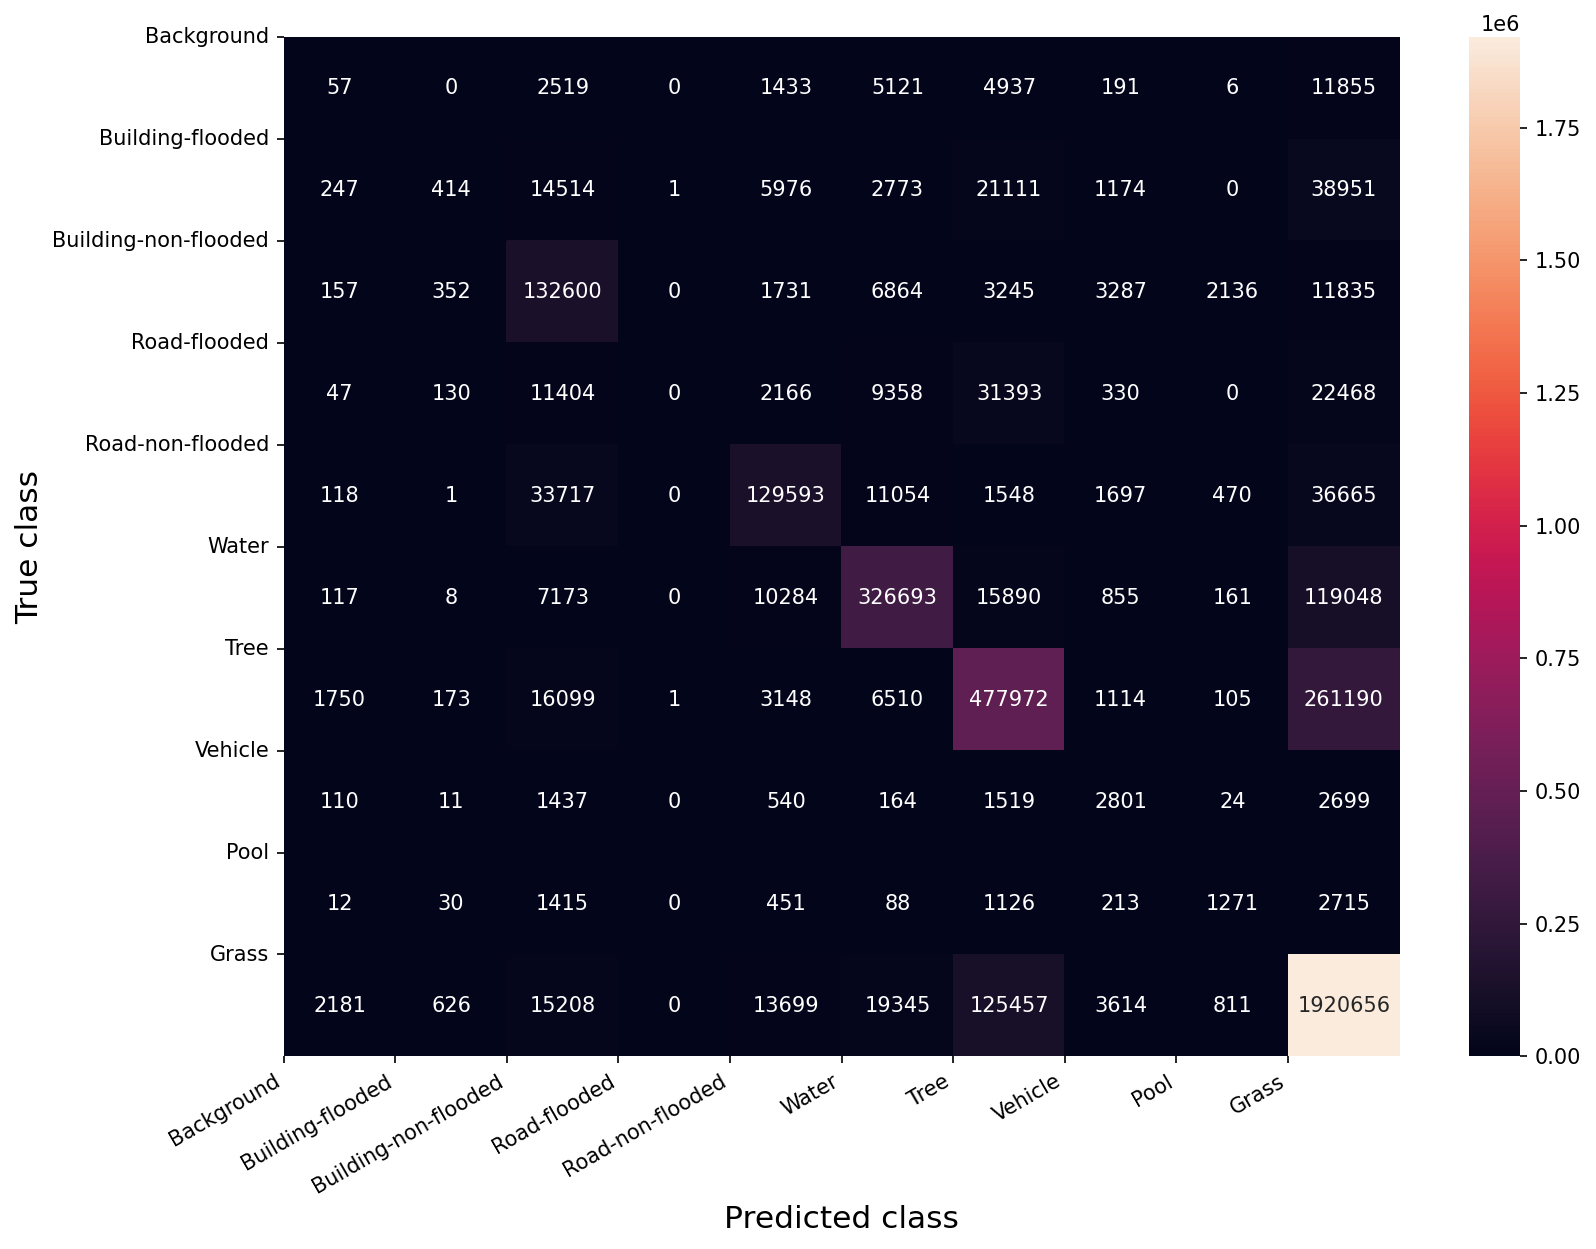

In [ ]:
# test data

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

nb_classes = 10

plt.figure(dpi=150, figsize=(12,9))

label_names = ['Background','Building-flooded','Building-non-flooded','Road-flooded','Road-non-flooded','Water','Tree','Vehicle','Pool','Grass']
class_names = [0,1,2,3,4,5,6,7,8,9]
df_cm = pd.DataFrame(confusion_test, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True class', fontsize = 15)
plt.xlabel('Predicted class', fontsize = 15)
plt.xticks(np.arange(len(label_names)), label_names, fontsize = 10, rotation=30)
plt.yticks(np.arange(len(label_names)), label_names, fontsize = 10)
# plt.savefig('/content/drive/MyDrive/IPEO_project_data/results/matrix_test_4.png')


### valid

([<matplotlib.axis.YTick at 0x7fa7c835eeb0>,
 [Text(0, 0.5, 'Background'),
  Text(0, 1.5, 'Building-flooded'),
  Text(0, 2.5, 'Building-non-flooded'),
  Text(0, 3.5, 'Road-flooded'),
  Text(0, 4.5, 'Road-non-flooded'),
  Text(0, 5.5, 'Water'),
  Text(0, 6.5, 'Tree'),
  Text(0, 7.5, 'Vehicle'),
  Text(0, 8.5, 'Pool'),
  Text(0, 9.5, 'Grass')])

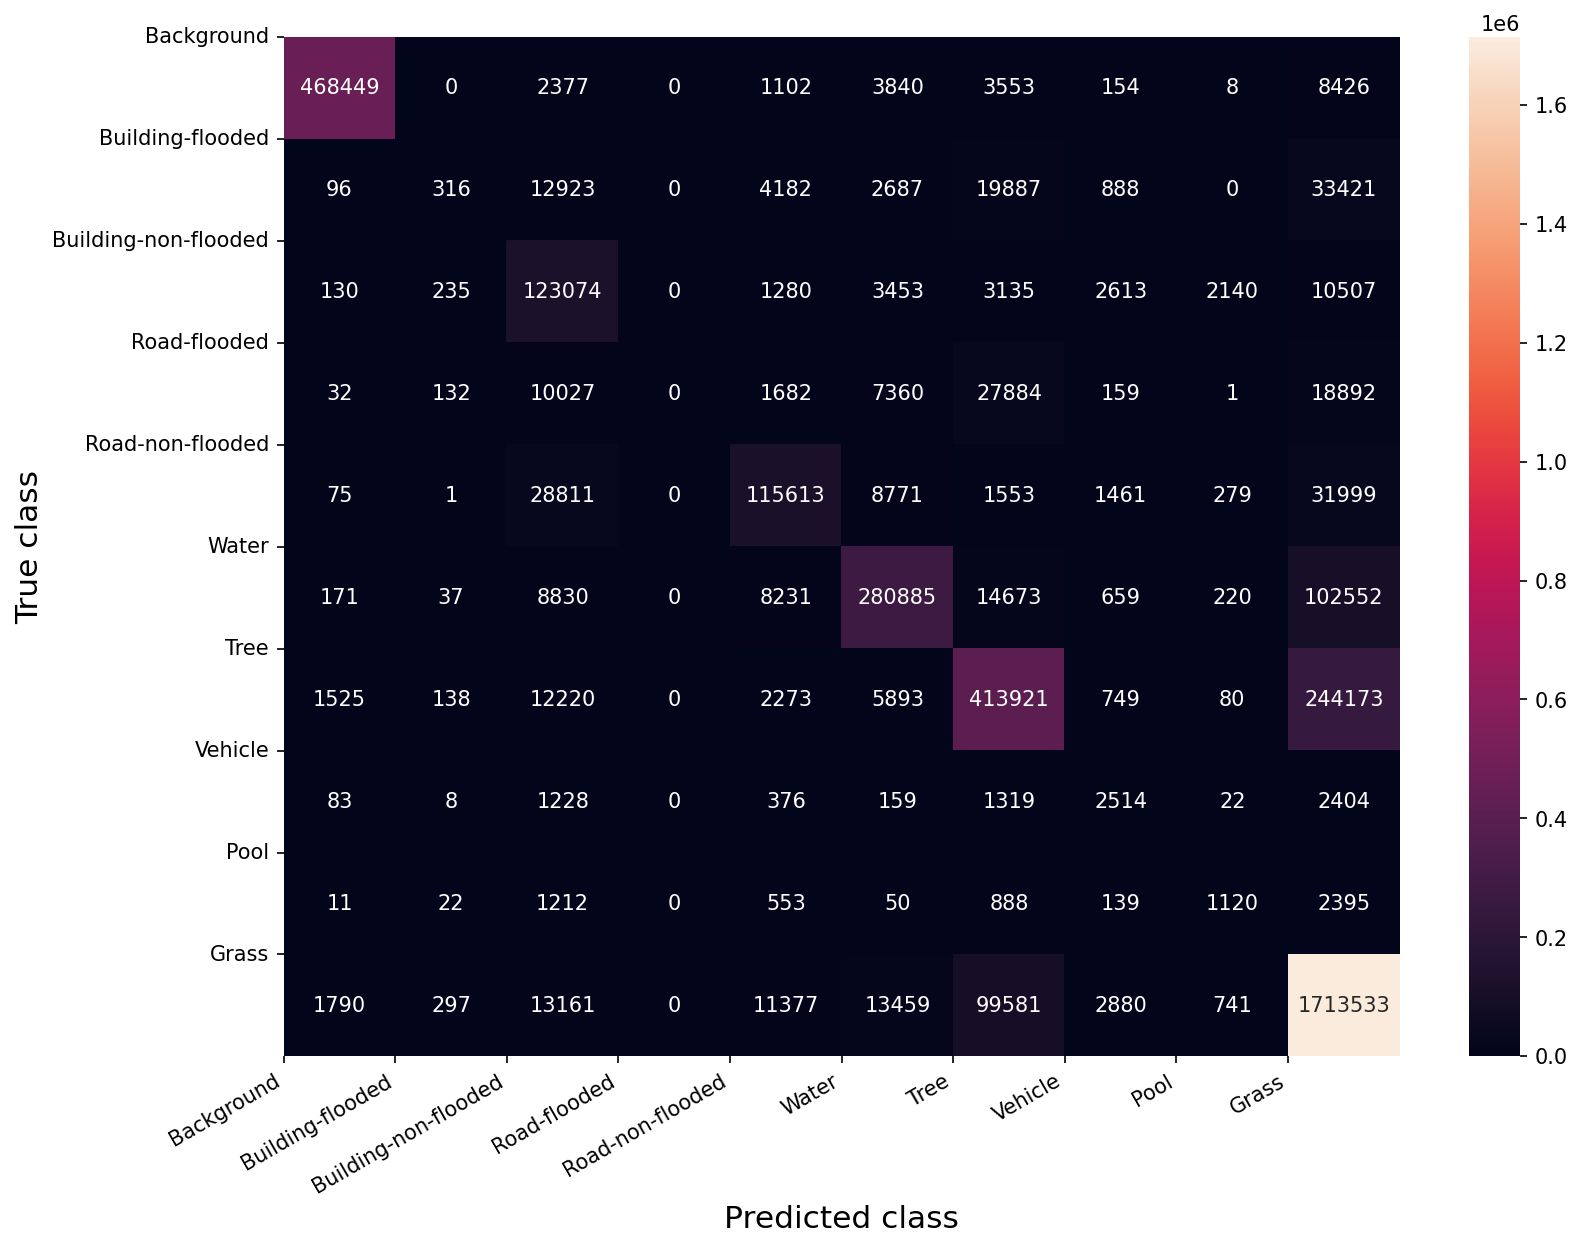

In [ ]:
# valid data

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

nb_classes = 10

plt.figure(dpi=150, figsize=(12,9))

label_names = ['Background','Building-flooded','Building-non-flooded','Road-flooded','Road-non-flooded','Water','Tree','Vehicle','Pool','Grass']
class_names = [0,1,2,3,4,5,6,7,8,9]
df_cm = pd.DataFrame(confusion_val, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True class', fontsize = 15)
plt.xlabel('Predicted class', fontsize = 15)
plt.xticks(np.arange(len(label_names)), label_names, fontsize = 10, rotation=30)
plt.yticks(np.arange(len(label_names)), label_names, fontsize = 10)
# plt.savefig('/content/drive/MyDrive/IPEO_project_data/results/matrix_valid_4.png')


### train

([<matplotlib.axis.YTick at 0x7fa7c81d56d0>,
 [Text(0, 0.5, 'Background'),
  Text(0, 1.5, 'Building-flooded'),
  Text(0, 2.5, 'Building-non-flooded'),
  Text(0, 3.5, 'Road-flooded'),
  Text(0, 4.5, 'Road-non-flooded'),
  Text(0, 5.5, 'Water'),
  Text(0, 6.5, 'Tree'),
  Text(0, 7.5, 'Vehicle'),
  Text(0, 8.5, 'Pool'),
  Text(0, 9.5, 'Grass')])

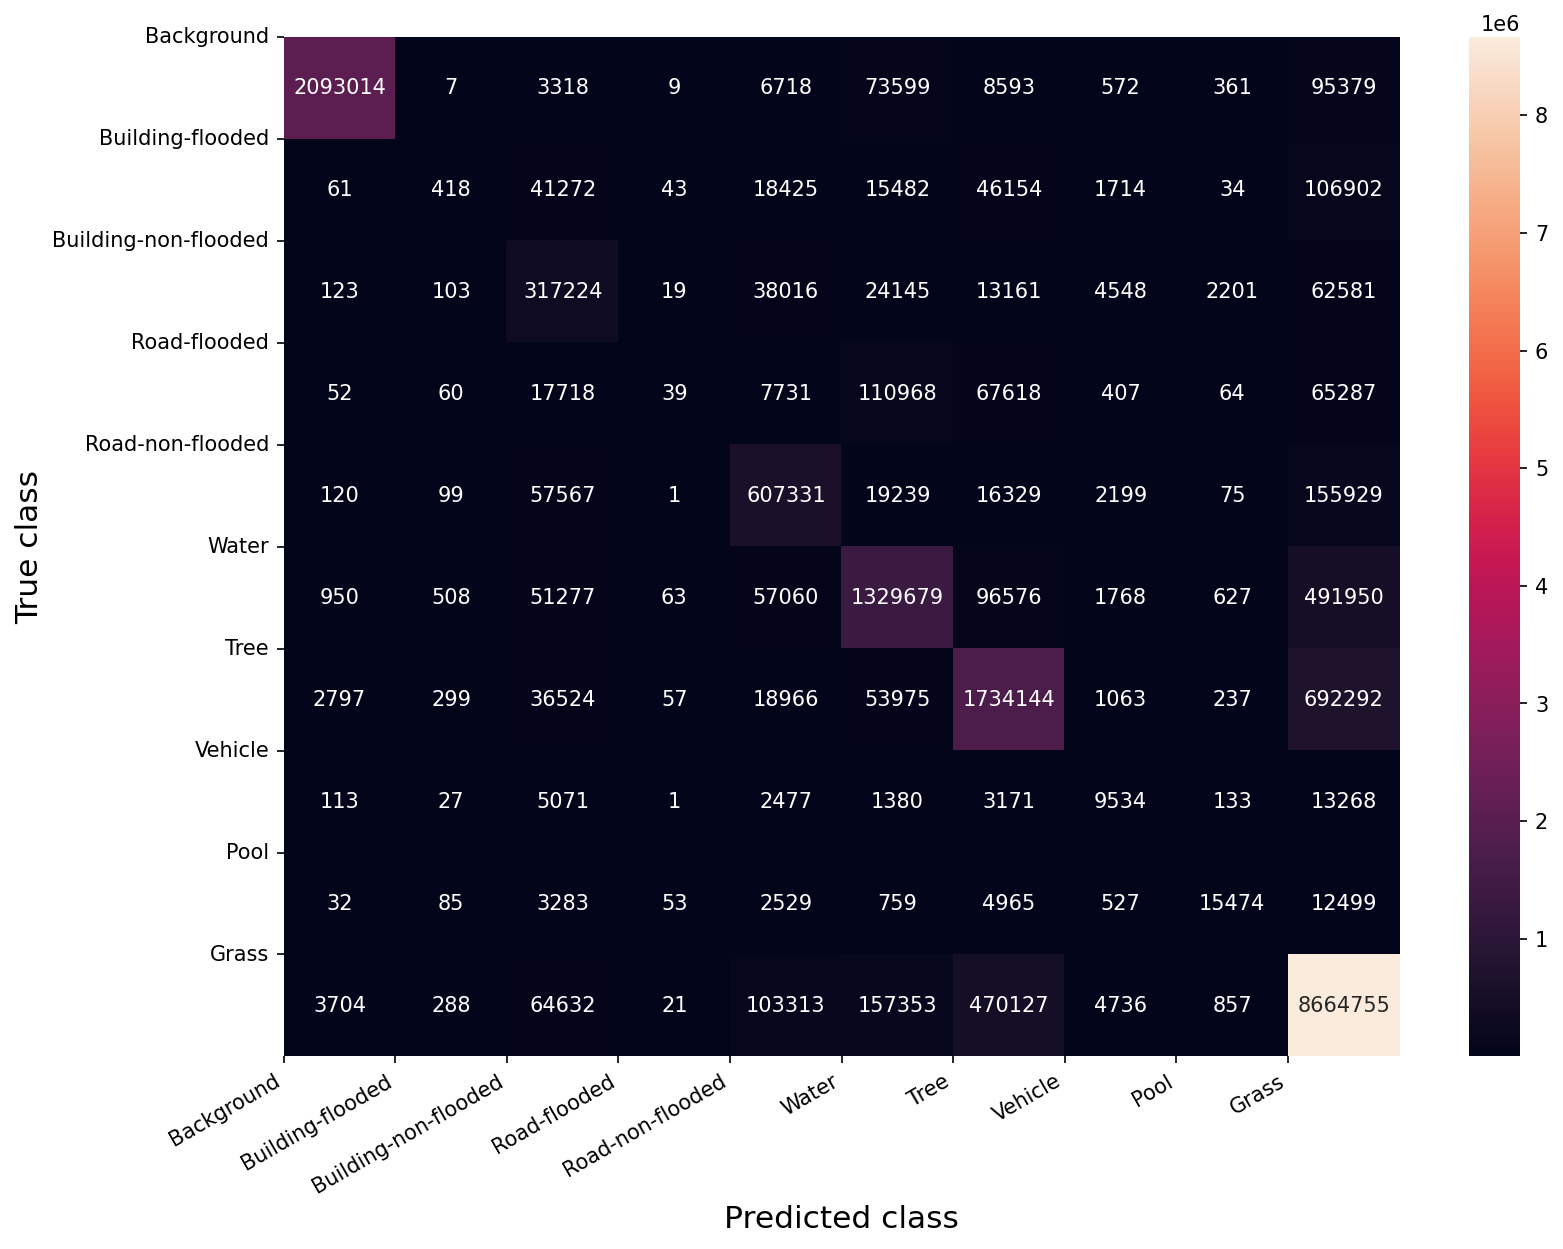

In [ ]:
# train data

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

nb_classes = 10

plt.figure(dpi=150, figsize=(12,9))

label_names = ['Background','Building-flooded','Building-non-flooded','Road-flooded','Road-non-flooded','Water','Tree','Vehicle','Pool','Grass']
class_names = [0,1,2,3,4,5,6,7,8,9]
df_cm = pd.DataFrame(confusion_train, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True class', fontsize = 15)
plt.xlabel('Predicted class', fontsize = 15)
plt.xticks(np.arange(len(label_names)), label_names, fontsize = 10, rotation=30)
plt.yticks(np.arange(len(label_names)), label_names, fontsize = 10)
# plt.savefig('/content/drive/MyDrive/IPEO_project_data/results/matrix_train_4.png')


## 5.4 Accuracy of each class

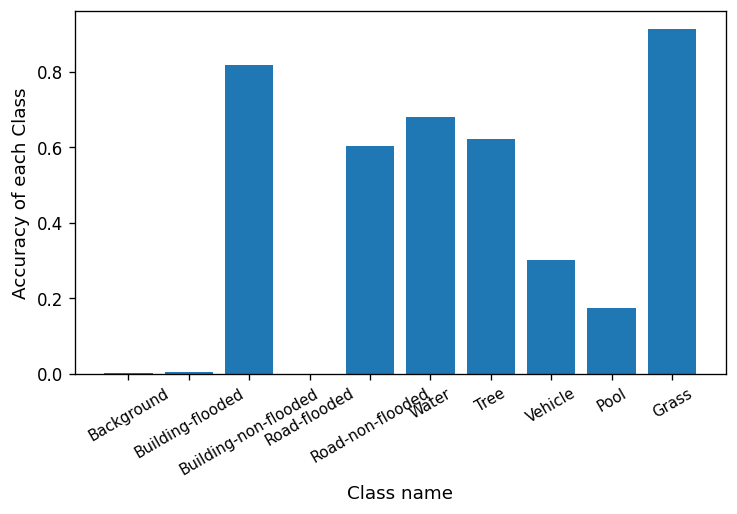

In [ ]:
# test data
test_diag = []
for i in range(10):
    diag = confusion_test[i][i]
    test_diag.append(diag)
label_ac=test_diag/confusion_test.sum(1)

plt.figure(dpi=120, figsize=(7,4))
plt.bar(range(len(label_ac)), label_ac)
plt.ylabel('Accuracy of each Class', fontsize = 11)
plt.xlabel('Class name', fontsize = 11)
plt.xticks(np.arange(len(label_names)), label_names, fontsize = 9, rotation=30)
# plt.savefig('/content/drive/MyDrive/IPEO_project_data/results/label_test_4.png')
plt.show()

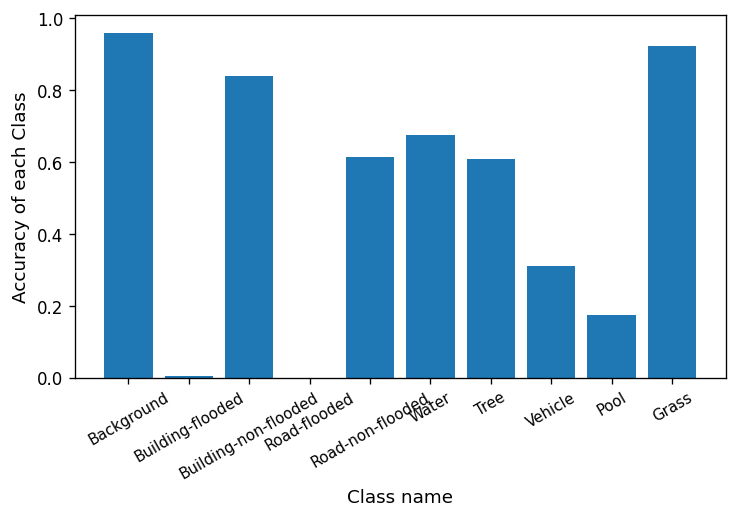

In [ ]:
# valid data
val_diag = []
for i in range(10):
    diag = confusion_val[i][i]
    val_diag.append(diag)
label_ac=val_diag/confusion_val.sum(1)

plt.figure(dpi=120, figsize=(7,4))
plt.bar(range(len(label_ac)), label_ac)
plt.ylabel('Accuracy of each Class', fontsize = 11)
plt.xlabel('Class name', fontsize = 11)
plt.xticks(np.arange(len(label_names)), label_names, fontsize = 9, rotation=30)
# plt.savefig('/content/drive/MyDrive/IPEO_project_data/results/label_valid_4.png')
plt.show()

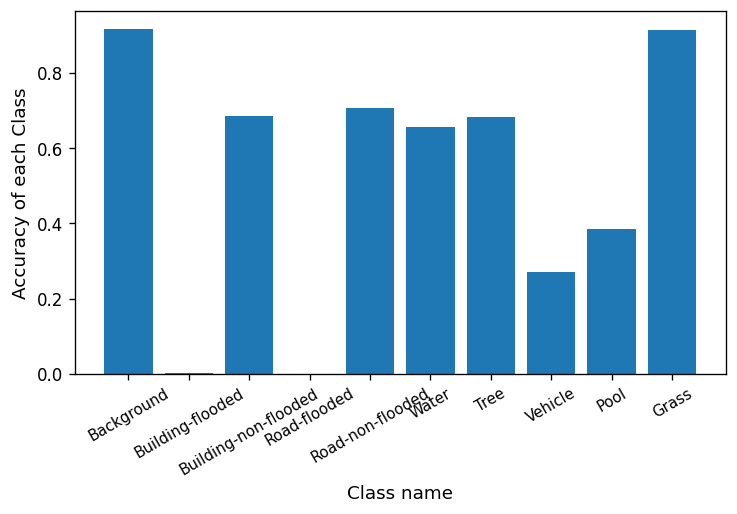

In [ ]:
# train data
train_diag = []
for i in range(10):
    diag = confusion_train[i][i]
    train_diag.append(diag)
label_ac=train_diag/confusion_train.sum(1)

plt.figure(dpi=120, figsize=(7,4))
plt.bar(range(len(label_ac)), label_ac)
plt.ylabel('Accuracy of each Class', fontsize = 11)
plt.xlabel('Class name', fontsize = 11)
plt.xticks(np.arange(len(label_names)), label_names, fontsize = 9, rotation=30)
# plt.savefig('/content/drive/MyDrive/IPEO_project_data/results/label_train_4.png')
plt.show()

## 5.5 Visualization

display prediction examples from test set

In [ ]:
# get true and prected masks
y_trues = []
y_preds = []

#for i in range(len(test_loader)):
for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)#.float()
    labels = labels.to(device)#.float()
  
    # Predict
    outputs = model(inputs)
    pred = torch.sigmoid(outputs)
    pred = pred.data.cpu().numpy()
    y_preds.append(pred)
    y_trues.append(labels)

In [ ]:
# transform predicted masks
import cv2
def reverse_transform_mask(inp):
    inp=inp.transpose((1, 2, 0))
    t_mask=np.argmax(inp,axis=2).astype('float32') 
    t_mask=cv2.resize(t_mask, dsize=(4000, 3000))
    kernel = np.ones((3,3),np.uint8)
    t_mask = cv2.erode(t_mask, kernel, iterations=1)
    return t_mask

mask_preds = []
for i in range(len(y_preds)):
    a = y_preds[i][0]
    a = reverse_transform_mask(a)
    mask_preds.append(a)

In [ ]:
# tranform true masks
mask_trues = []
for i in range(len(y_trues)):
    b = y_trues[i].cpu().numpy().squeeze()
    b = cv2.resize(b, dsize=(4000, 3000))
    mask_trues.append(b)

In [ ]:
# transform true images
import cv2
x_trues = []
std_inv = 1 / (std + 1e-7)
unnormalize = transforms.Normalize(-mean * std_inv, std_inv)

for batch_idx, (inputs, labels) in enumerate(test_loader):
  inputs = inputs[0].squeeze()
  inputs = unnormalize(inputs).permute((1, 2, 0)).numpy().astype(np.uint8)
  inputs = cv2.resize(inputs, dsize=(4000, 3000))
  x_trues.append(inputs)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

label_names = ['Background','Building-flooded','Building-non-flooded','Road-flooded','Road-non-flooded','Water','Tree','Vehicle','Pool','Grass']
color = ['black', 'red', 'darkred', 'orange', 'grey', 'cyan', 'green', 'pink', 'olive', 'lightgreen']
patches = [mpatches.Patch(color=color[i], label="{:s}".format(label_names[i])) for i in range(len(color))]
cmap = ListedColormap(color)
norm = BoundaryNorm([-1,0.1,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1], cmap.N)
nums = [5, 17, 25, 28, 57]


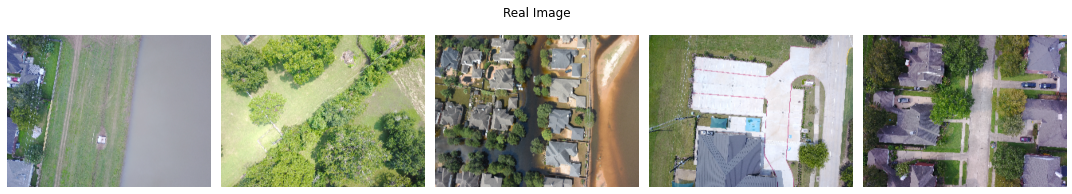

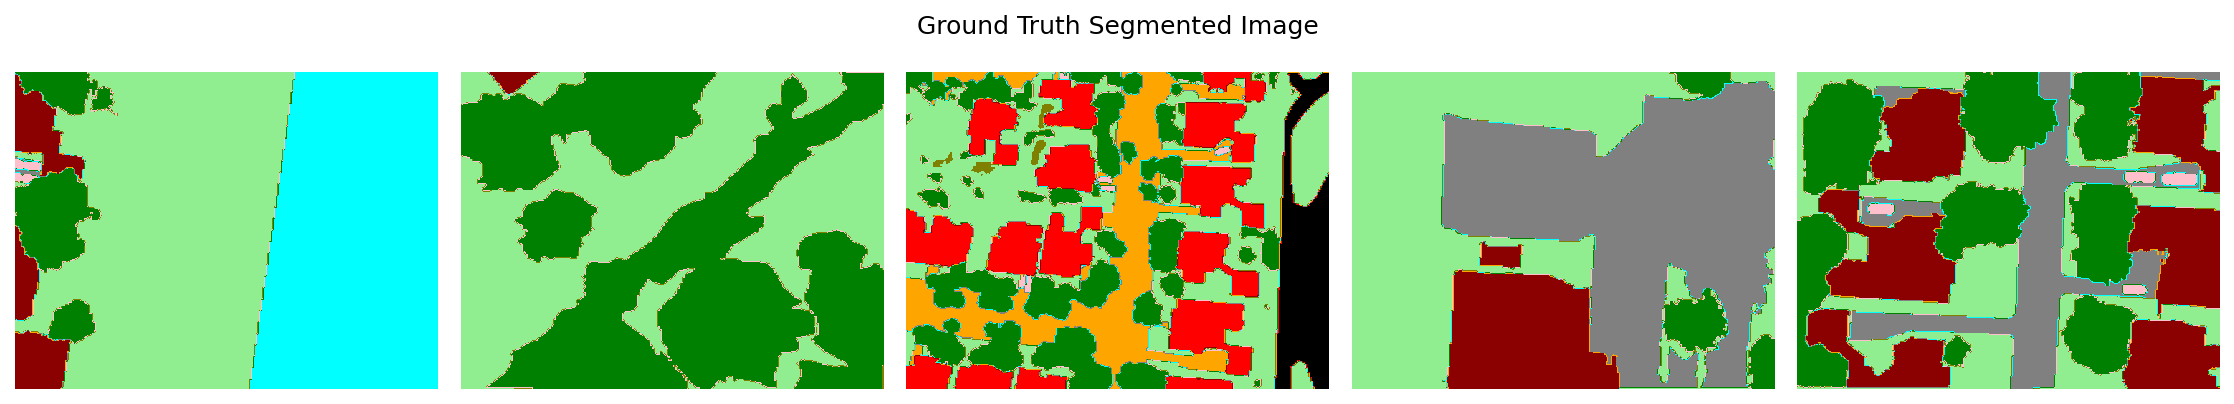

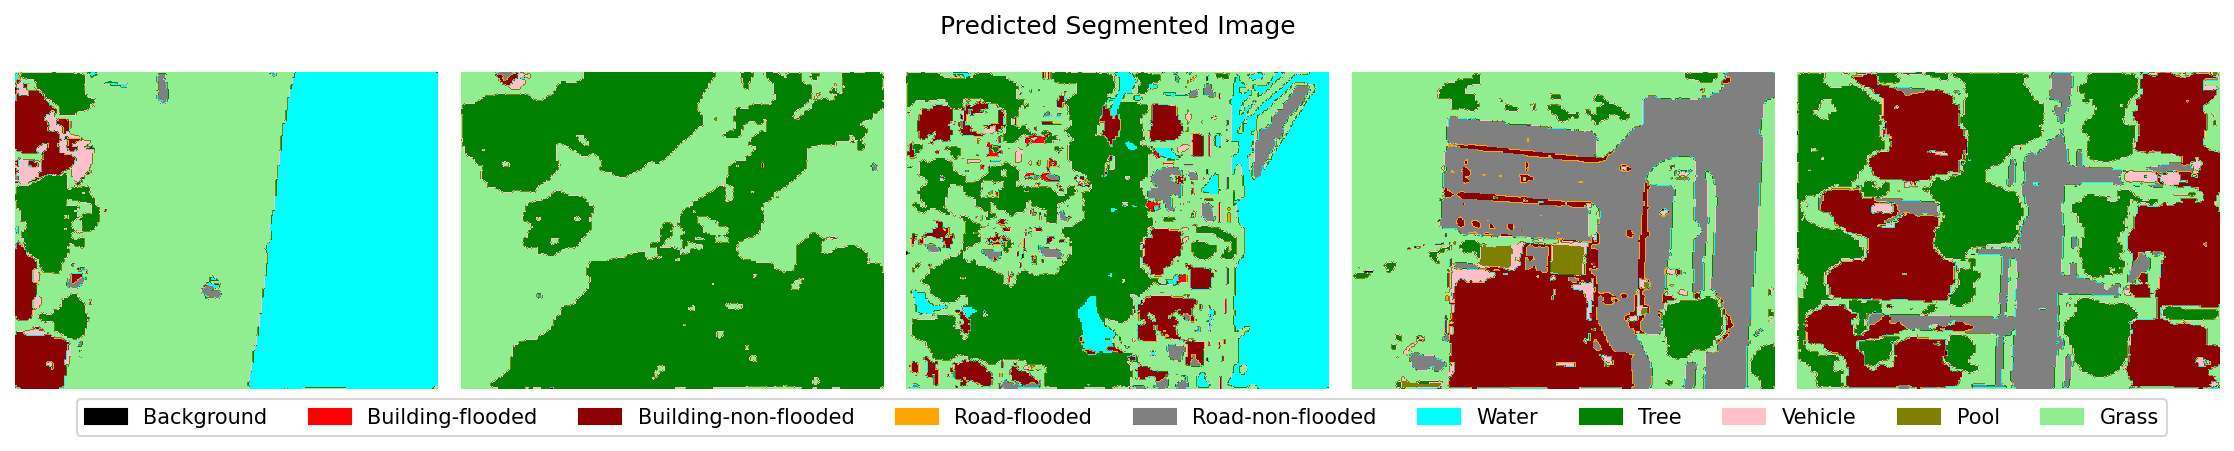

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(5*3, 3))
for i in range(5):
    axs[i].imshow(x_trues[nums[i]]) 
    axs[i].axis("off")   
fig.suptitle("Real Image")
plt.tight_layout()

# display ground truth segmented images
fig, axs = plt.subplots(1,5, figsize=(5*3, 3), dpi=150)
for i in range(5):
    axs[i].imshow(mask_trues[nums[i]], cmap=cmap, interpolation='none', norm=norm) 
    axs[i].axis("off")   
fig.suptitle("Ground Truth Segmented Image")
plt.tight_layout()


# display predicted segmented images
fig, axs = plt.subplots(1,5, figsize=(5*3, 3), dpi=150)
for i in range(5):
    axs[i].imshow(mask_preds[nums[i]], cmap=cmap, interpolation='none', norm=norm) 
    axs[i].axis("off")   
fig.suptitle("Predicted Segmented Image")
plt.tight_layout()

ax = plt.gca()
ax.legend(handles=patches, bbox_to_anchor=(0.9, 0), ncol=10)   # add legend